In [1]:
import transformer_model
import numpy as np
import random
import matplotlib.pyplot as plt

# Bring in PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
# Most of the examples have typing on the signatures for readability

import pandas as pd

import pickle

/home/mihriban/gf_transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
angles = torch.load('new_training/angles.pt').to(device)

#angles = angles[:,:,:].to(device)
#print(angles.size())
#print(angles[2,:,:])

embeddings = torch.load('new_training/embeddings.pt').to(device)
#embeddings = embeddings[:,:,:].to(device)
#print(embeddings.size())

# Ensure this matches the file path used when saving
with open('new_training/sequences.pkl', 'rb') as f:
        sequences = pickle.load(f)
#print(sequences)
#print(len(sequences)) #here len is not the length of sequence, but number of sequences in total

df = pd.read_csv('training/dataframe.csv')

torch.Size([200, 2, 131])
tensor([[-141.9378,  -54.4260,  120.0776, -117.7217,  -65.1279,  126.1860,
         -155.8193,  -44.0387,  169.9281,  -70.0933,  -59.9047,  -71.4219,
          -67.8545,  -68.4882,  -41.2299,  -73.3059,  -51.9597,  -67.8711,
          -52.3634,  -77.0797,  -70.3211,  -52.6544,  -43.1080,  -73.2480,
          -37.9730,  -83.1987,  -40.2596,  -62.5347,  -46.5066,  -40.2015,
          -51.3487,  155.3039, -117.2427,  -54.1185,  -44.8753,  -49.8973,
          -51.9727,  -40.8807,  -42.0868,  -45.3178,  -50.8892,  -48.4963,
          -42.0418,  -58.5913,  -60.4675,  -50.6514,  -61.7419,  -48.0662,
          -72.3852,  -42.9112,  -94.9257,  -70.6135,  -66.7195,   57.7410,
          -95.7009, -120.0162,   40.8753,  -82.5702,   65.2589,  -59.2909,
         -103.5309,  -65.1988,  -85.9520,  -68.3044,  -79.7157,  -39.9021,
          -42.6408,  -55.8524,  -49.5473,  -63.9239,  -90.6485,  -37.5335,
          -54.2214,  -37.6554,  -47.7194,  -46.8670,  -42.7844,  -81.0891,

In [ ]:
create_mask = transformer_model.create_mask()
feed_forward_dim1 = 512
feed_forward_dim2 = 256
num_epochs = 200
dropout_rate = 0.1

model = transformer_model.TransformerModel(embed_dim=1024, feed_forward_dim1=feed_forward_dim1, feed_forward_dim2= feed_forward_dim2, dropout_rate = dropout_rate)
model = model.to(device)
criterion = transformer_model.AngularLoss()

N= 130
D = 1024
indices = np.arange(0, len(sequences))
random.shuffle(indices) # shuffling data




lengths = torch.tensor(df['len'].values)
print(lengths.shape)
angles_tensor = (angles.T)*(np.pi/180)



In [8]:
class TransformerTrainer:
    def __init__(self, model: nn.Module, criterion: nn.Module, num_epochs: int, sequence: torch.Tensor, angles: torch.Tensor):
        self.model = model
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.sequence = sequence
        self.angles_tensor = angles
        self.optimizer = optim.AdamW(model.parameters(), lr=0.001)

    def train(self):
        loss_list = []
        val_loss = []
        indices = np.arange(0, len(self.sequence[:,0,0])) # shuffling the indices around, maybe we can do it after the epoch for more shuffling
        random.shuffle(indices)
        

        #now im going to include validation
        val_indices = indices[int(0.8 * len(indices)):int(0.9 * len(indices))]

        for epoch in range(self.num_epochs):
          for idx in indices[:int(0.8*len(self.sequence[:,0,0]))]: #im taking 80 percent of the dataset
            self.optimizer.zero_grad()
            predictions = self.model.forward(self.sequence[idx,:,:], create_mask(indices = idx))
            
            loss = self.criterion(idx,predictions.squeeze(), self.angles_tensor)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            
            loss_list.append(loss.item())

          #validation loop
          self.model.eval()
           
          with torch.no_grad():
              for idx_val in val_indices:
                mask = create_mask(idx_val)
                predictions = self.model(self.sequence[idx,:,:], mask)
                loss = self.criterion(idx, predictions.squeeze(), self.angles_tensor)
                val_loss.append(loss.item())


          #print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {loss.item()}")
          #torch.save(self.model.state_dict(), 'model_postraining.pt')
          print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {loss_list[-1]}, Validation Loss: {val_loss[-1]}")

        return val_loss
        #return loss

In [9]:
trainer = TransformerTrainer(model, criterion, num_epochs, embeddings , angles_tensor)#, mask)
loss = trainer.train()

torch.Size([1723])


/tmp/ipykernel_291331/4247984530.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  angles_tensor = (angles.T)*(np.pi/180)


Epoch 1/200, Training Loss: 0.01889672689139843, Validation Loss: 0.01815459504723549
Epoch 2/200, Training Loss: 0.017194699496030807, Validation Loss: 0.01718907803297043
Epoch 3/200, Training Loss: 0.016899656504392624, Validation Loss: 0.016898680478334427
Epoch 4/200, Training Loss: 0.01723022386431694, Validation Loss: 0.01708373613655567
Epoch 5/200, Training Loss: 0.01781909167766571, Validation Loss: 0.017576251178979874
Epoch 6/200, Training Loss: 0.018375657498836517, Validation Loss: 0.01823590323328972
Epoch 7/200, Training Loss: 0.018184833228588104, Validation Loss: 0.017924850806593895
Epoch 8/200, Training Loss: 0.01768319495022297, Validation Loss: 0.017733756452798843
Epoch 9/200, Training Loss: 0.01745620183646679, Validation Loss: 0.017353970557451248
Epoch 10/200, Training Loss: 0.018088888376951218, Validation Loss: 0.017878230661153793
Epoch 11/200, Training Loss: 0.0171675905585289, Validation Loss: 0.017184417694807053
Epoch 12/200, Training Loss: 0.0174550283

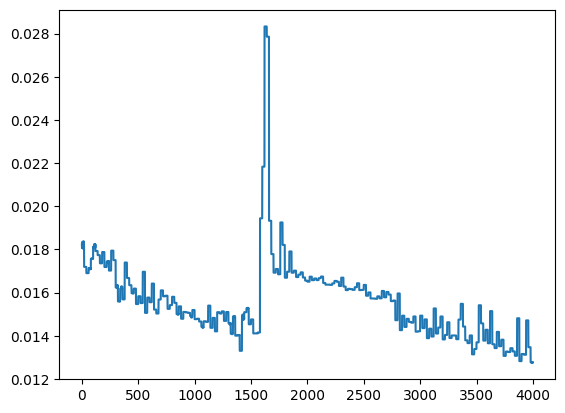

In [11]:
plt.plot(loss)